In [112]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series decomposition
#!pip install stldecompose
#from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [82]:
df = pd.read_pickle('btcusdt_1d_ohlcv_av_1Jan2019_to_24Sep2021_1day.pkl')

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1190 entries, 0 to 1189
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   open_time          1190 non-null   datetime64[ns]
 1   BTCUSDT_open       1190 non-null   float64       
 2   BTCUSDT_high       1190 non-null   float64       
 3   BTCUSDT_low        1190 non-null   float64       
 4   BTCUSDT_close      1190 non-null   float64       
 5   BTCUSDT_volume     1190 non-null   float64       
 6   close_time         1190 non-null   datetime64[ns]
 7   qav                1190 non-null   float64       
 8   num_trades         1190 non-null   int64         
 9   taker_base_vol     1190 non-null   float64       
 10  taker_quote_vol    1190 non-null   float64       
 11  is_best_match      1190 non-null   int64         
 12  date               1190 non-null   datetime64[ns]
 13  usd_close          172 non-null    float64       
 14  spy_clos

In [84]:
# we decide to only take dates in 2021, as we tested XGboost previously on the whole dataset and the errors were very high
df = df.loc[df['year'] == 2021]

In [85]:
df

,open_time,BTCUSDT_open,BTCUSDT_high,BTCUSDT_low,BTCUSDT_close,BTCUSDT_volume,close_time,qav,num_trades,taker_base_vol,...,nfp_close,btc_txn_vol,btc_wallet_unique,btc_blk_size_mb,year,month,date_of_month,day_of_week,day_of_year,hour_of_day
870,2021-01-01,28923.63,29600.00,28624.57,29331.69,54182.925011,2021-01-01 23:59:59.999000064,1.582527e+09,1314910,27455.801725,...,140980.0,4.343208e+09,63499165.0,1.256575,2021,1,1,4,1,59
871,2021-01-02,29331.70,33300.00,28946.53,32178.33,129993.873362,2021-01-02 23:59:59.999000064,4.073842e+09,2245922,67446.305246,...,140980.0,4.343208e+09,63569361.0,1.395637,2021,1,2,5,2,59
872,2021-01-03,32176.45,34778.11,31962.99,33000.05,120957.566750,2021-01-03 23:59:59.999000064,4.057598e+09,2369698,59750.332871,...,140980.0,4.343208e+09,63652587.0,1.395637,2021,1,3,6,3,59
873,2021-01-03,32176.45,34778.11,31962.99,33000.05,120957.566750,2021-01-03 23:59:59.999000064,4.057598e+09,2369698,59750.332871,...,140980.0,4.343208e+09,63751223.0,1.395637,2021,1,3,6,3,59
874,2021-01-04,33000.05,33600.00,28130.00,31988.71,140899.885690,2021-01-04 23:59:59.999000064,4.429010e+09,2642408,69088.469230,...,140980.0,7.503148e+09,63842886.0,1.395637,2021,1,4,0,4,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,2021-09-20,47241.75,47347.25,42500.00,43015.62,78003.524443,2021-09-20 23:59:59.999000064,3.457139e+09,1842231,36108.362951,...,146856.0,1.797163e+09,76764696.0,1.214339,2021,9,20,0,263,59
1186,2021-09-21,43016.64,43639.00,39600.00,40734.38,84534.080485,2021-09-21 23:59:59.999000064,3.551998e+09,1820721,38942.743560,...,146856.0,1.797163e+09,76781174.0,1.214339,2021,9,21,1,264,59
1187,2021-09-22,40734.09,44000.55,40565.39,43543.61,58349.055420,2021-09-22 23:59:59.999000064,2.482639e+09,1304011,29321.506600,...,146856.0,3.589502e+09,76800690.0,1.214339,2021,9,22,2,265,59
1188,2021-09-23,43546.37,44978.00,43069.09,44865.26,48699.576550,2021-09-23 23:59:59.999000064,2.147211e+09,1196106,24503.003650,...,146856.0,3.589502e+09,76810295.0,1.016578,2021,9,23,3,266,59


In [86]:
df.index = range(len(df))

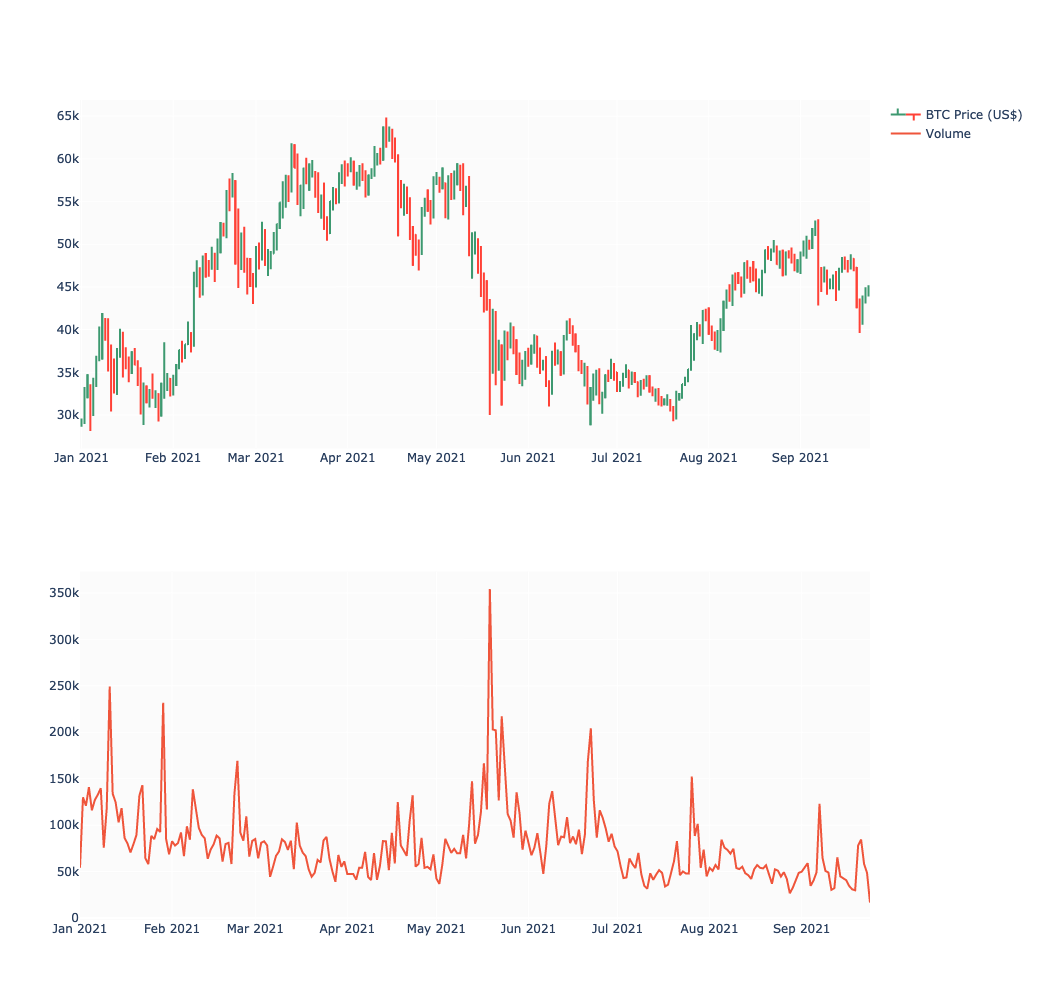

In [87]:
fig = make_subplots(rows=2, cols=1)

fig.update_layout(
    autosize=False,
    width=1200,
    height=1000)

fig.add_trace(go.Ohlc(x=df.date,
                      open=df.BTCUSDT_open,
                      high=df.BTCUSDT_high,
                      low=df.BTCUSDT_low,
                      close=df.BTCUSDT_close,
                      name='BTC Price (US$)'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.date, y=df.BTCUSDT_volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

<Figure size 640x480 with 0 Axes>

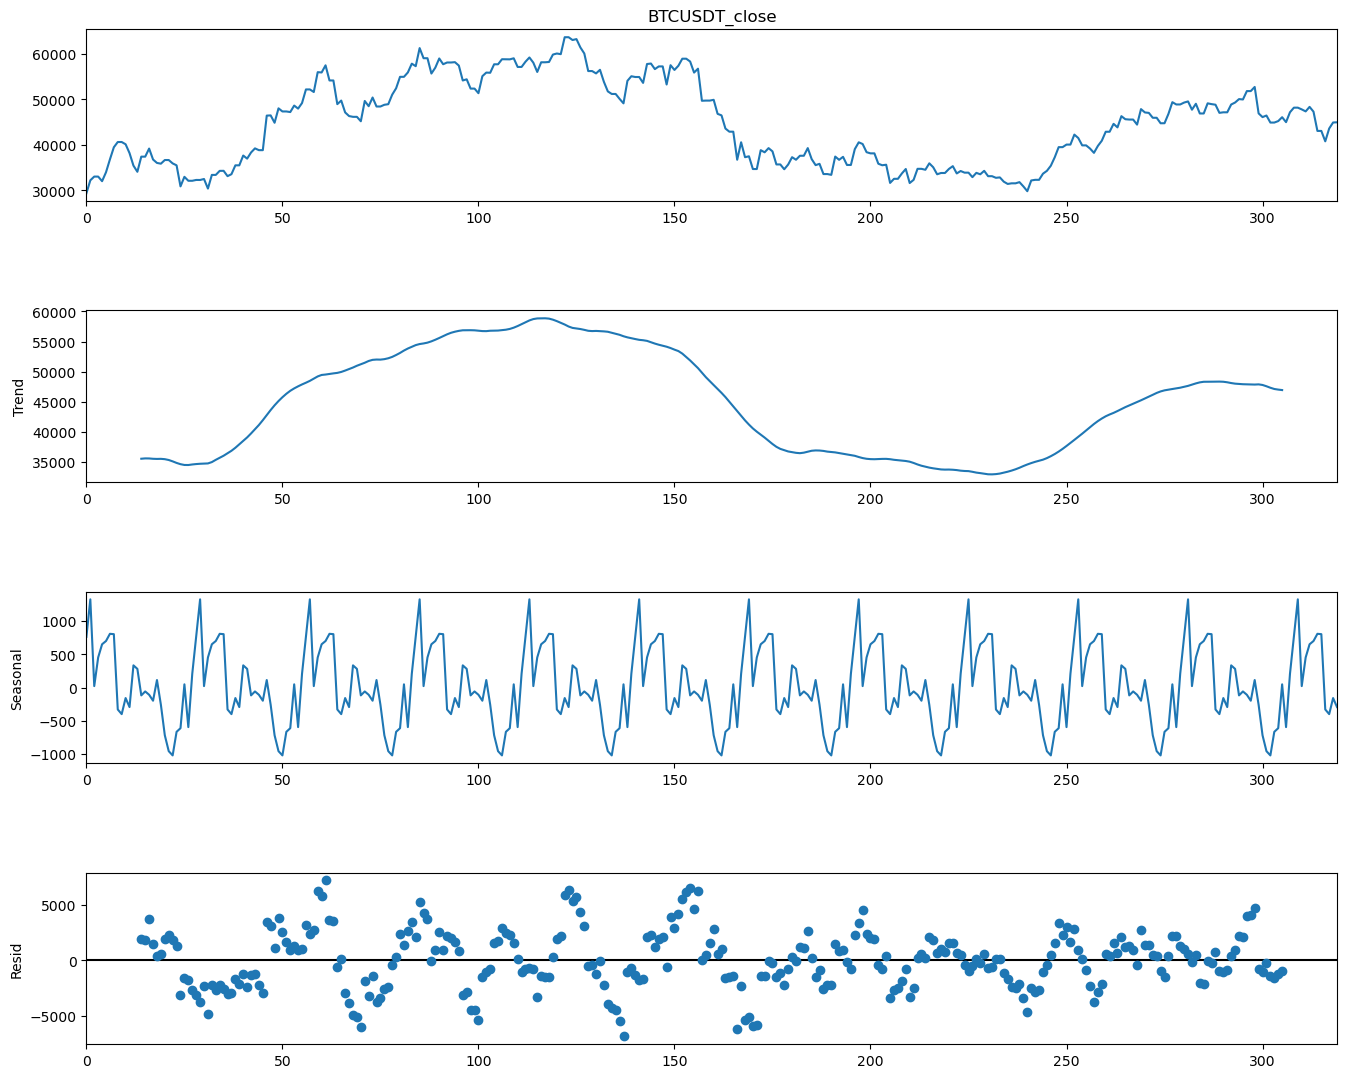

In [88]:
from statsmodels.tsa.seasonal import seasonal_decompose
#frequency of 28 as we want to explor the relatiionship for monthly btc option expiries
result = seasonal_decompose(df['BTCUSDT_close'], model='additive', freq=28) 

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)
plt.show()

### Feature Engineering, Add Technical Indicators

#### Moving Averages

In [89]:
df['EMA_9'] = df['BTCUSDT_close'].ewm(9).mean().shift()
df['SMA_5'] = df['BTCUSDT_close'].rolling(5).mean().shift()
df['SMA_10'] = df['BTCUSDT_close'].rolling(10).mean().shift()
df['SMA_15'] = df['BTCUSDT_close'].rolling(15).mean().shift()
df['SMA_30'] = df['BTCUSDT_close'].rolling(30).mean().shift()

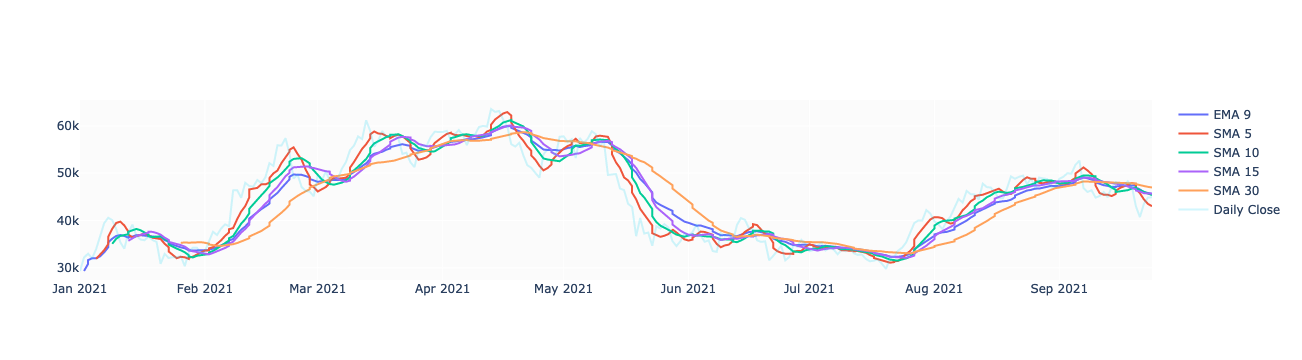

In [90]:
#plot moving averages and exponential moving averages
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.date, y=df.BTCUSDT_close, name='Daily Close', opacity=0.2))
fig.show()

#### Momentum Indicators

#define an RSI function
https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas

In [91]:
def relative_strength_idx(df, n=14):
    close = df['BTCUSDT_close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

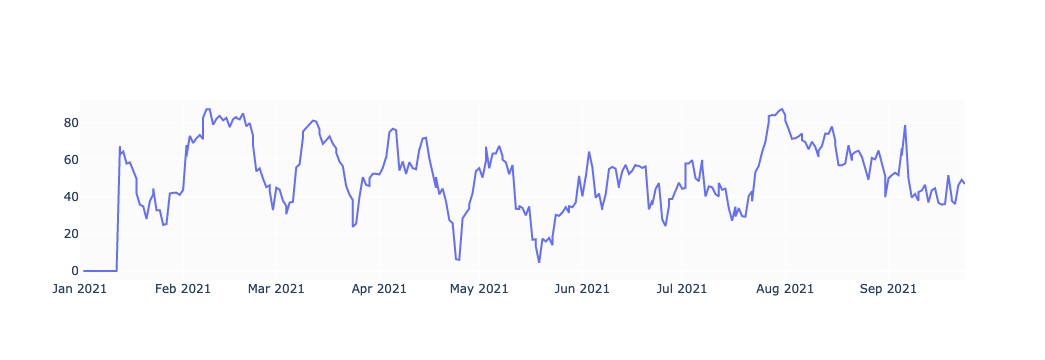

In [92]:
df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.date, y=df.RSI, name='RSI'))
fig.show()

#define a MACD function
https://www.investopedia.com/terms/m/macd.asp

In [93]:
EMA_12 = pd.Series(df['BTCUSDT_close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['BTCUSDT_close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

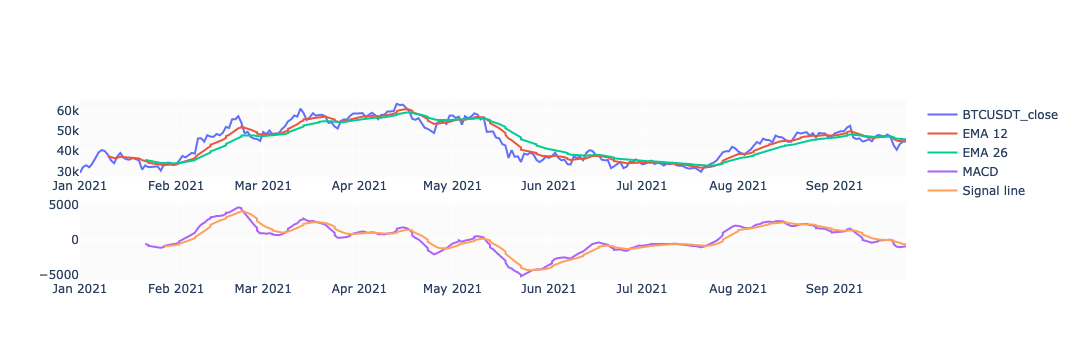

In [94]:
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.date, y=df.BTCUSDT_close, name='BTCUSDT_close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

### Prediction Objective:
We aim to predict the next day price
***
Steps:
1. time shift column, by 1 day with .shift(-1)
2. drop all NA values (with the TA, we can assume that there might be some NaN values at the starting date of the dataset)
3. Initiate model, score accuracy and make predictions

#### 1. Shift label column

In [95]:
df['BTCUSDT_close'] = df['BTCUSDT_close'].shift(-1)

#### 2.0 Drop NaN values due to TA

In [96]:
df.head(38)

,open_time,BTCUSDT_open,BTCUSDT_high,BTCUSDT_low,BTCUSDT_close,BTCUSDT_volume,close_time,qav,num_trades,taker_base_vol,...,day_of_year,hour_of_day,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2021-01-01,28923.63,29600.00,28624.57,32178.33,54182.925011,2021-01-01 23:59:59.999000064,1.582527e+09,1314910,27455.801725,...,1,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-02,29331.70,33300.00,28946.53,33000.05,129993.873362,2021-01-02 23:59:59.999000064,4.073842e+09,2245922,67446.305246,...,2,59,29331.690000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2,2021-01-03,32176.45,34778.11,31962.99,33000.05,120957.566750,2021-01-03 23:59:59.999000064,4.057598e+09,2369698,59750.332871,...,3,59,30829.921579,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
3,2021-01-03,32176.45,34778.11,31962.99,31988.71,120957.566750,2021-01-03 23:59:59.999000064,4.057598e+09,2369698,59750.332871,...,3,59,31630.706974,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
4,2021-01-04,33000.05,33600.00,28130.00,33949.53,140899.885690,2021-01-04 23:59:59.999000064,4.429010e+09,2642408,69088.469230,...,4,59,32028.887557,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
5,2021-01-05,31989.75,34360.00,29900.00,36769.36,116049.997038,2021-01-05 23:59:59.999000064,3.743617e+09,2526851,59691.754755,...,5,59,32019.076428,31899.766,NaN,NaN,NaN,0.000000,NaN,NaN
6,2021-01-06,33949.53,36939.21,33288.00,39432.28,127139.201310,2021-01-06 23:59:59.999000064,4.431954e+09,2591783,63052.914652,...,6,59,32431.074399,32823.334,NaN,NaN,NaN,0.000000,NaN,NaN
7,2021-01-07,36769.36,40365.00,36300.00,40582.81,132825.700437,2021-01-07 23:59:59.999000064,5.062570e+09,2814686,65055.107136,...,7,59,33262.636565,33741.540,NaN,NaN,NaN,0.000000,NaN,NaN
8,2021-01-08,39432.48,41950.00,36500.00,40582.81,139789.957499,2021-01-08 23:59:59.999000064,5.568443e+09,2925632,67300.155216,...,8,59,34345.918080,35027.986,NaN,NaN,NaN,0.000000,NaN,NaN
9,2021-01-08,39432.48,41950.00,36500.00,40088.22,139789.957499,2021-01-08 23:59:59.999000064,5.568443e+09,2925632,67300.155216,...,8,59,35364.053980,36544.538,NaN,NaN,NaN,0.000000,NaN,NaN


In [97]:
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

#### Train Test Split

Here I split data frame into three subsets: training (70%), validation (15%) and test (15%) sets. I calculated split indices and create three separate frames (train_df, valid_df, test_df). All three frames have been ploted in the chart below.

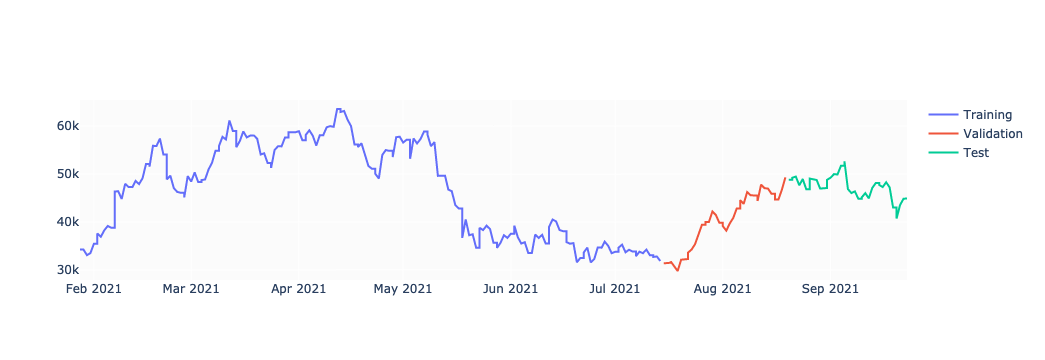

In [98]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.date, y=train_df.BTCUSDT_close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.date, y=valid_df.BTCUSDT_close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.date,  y=test_df.BTCUSDT_close,  name='Test'))
fig.show()

We should do some testing first, to see if the model can train correctly, since the environment is totally different now

In [99]:
df.columns

Index(['open_time', 'BTCUSDT_open', 'BTCUSDT_high', 'BTCUSDT_low',
       'BTCUSDT_close', 'BTCUSDT_volume', 'close_time', 'qav', 'num_trades',
       'taker_base_vol', 'taker_quote_vol', 'is_best_match', 'date',
       'usd_close', 'spy_close', 'ftse_china_close', 'gld_close', 'nfp_close',
       'btc_txn_vol', 'btc_wallet_unique', 'btc_blk_size_mb', 'year', 'month',
       'date_of_month', 'day_of_week', 'day_of_year', 'hour_of_day', 'EMA_9',
       'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30', 'RSI', 'MACD', 'MACD_signal'],
      dtype='object')

In [100]:
drop_cols = ['date', 'BTCUSDT_volume', 'BTCUSDT_open', 'BTCUSDT_low', 'BTCUSDT_high', 'open_time',
             'close_time', 'qav', 'taker_base_vol', 'taker_quote_vol', 'is_best_match',
            'year', 'month', 'date_of_month', 'day_of_week', 'day_of_year', 'hour_of_day',
             'ftse_china_close','usd_close','spy_close','gld_close','nfp_close']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

In [101]:
y_train = train_df['BTCUSDT_close'].copy()
X_train = train_df.drop(['BTCUSDT_close'], 1)

y_valid = valid_df['BTCUSDT_close'].copy()
X_valid = valid_df.drop(['BTCUSDT_close'], 1)

y_test  = test_df['BTCUSDT_close'].copy()
X_test  = test_df.drop(['BTCUSDT_close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   num_trades         201 non-null    int64  
 1   btc_txn_vol        201 non-null    float64
 2   btc_wallet_unique  201 non-null    float64
 3   btc_blk_size_mb    201 non-null    float64
 4   EMA_9              201 non-null    float64
 5   SMA_5              201 non-null    float64
 6   SMA_10             201 non-null    float64
 7   SMA_15             201 non-null    float64
 8   SMA_30             201 non-null    float64
 9   RSI                201 non-null    float64
 10  MACD               201 non-null    float64
 11  MACD_signal        201 non-null    float64
dtypes: float64(11), int64(1)
memory usage: 19.0 KB


#### 3.0 XGBoostRegressor Model

Run a gridsearchCV to look for best parameters to tune the model by

In [102]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

[17:05:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:05:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:11] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:11] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:11] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:11] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:11] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:12] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:12] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:12] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:13] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:13] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:14] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:14] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:18] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:18] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:18] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:20] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:21] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:22] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:23] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:23] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:23] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:23] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:23] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:23] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:24] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:24] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:25] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:25] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:26] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:26] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:26] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:27] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:27] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:28] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:28] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:29] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:30] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:31] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:31] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:32] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:32] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:32] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:32] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:32] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:33] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:33] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:34] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:34] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:34] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:35] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:35] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:35] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:36] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:36] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:37] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:37] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:38] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:39] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:39] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:39] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:40] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:40] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:40] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:40] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:42] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:42] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:43] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:43] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:44] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:06:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:11] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:11] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:12] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:13] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:14] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:18] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:20] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:21] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:22] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:24] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:25] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:28] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:30] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:30] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:30] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:30] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:31] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:31] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:32] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:32] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:33] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:33] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:34] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:35] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:36] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:37] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:38] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:38] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:40] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:42] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:43] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:44] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:44] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:44] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:07:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:11] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:11] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:11] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:11] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:12] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:12] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:12] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:12] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:13] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:13] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:14] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:14] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:14] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:18] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:18] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:18] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:18] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:19] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:19] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:19] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:20] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:20] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:21] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:21] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:22] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:22] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:23] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:24] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:24] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:24] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:24] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:24] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:24] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:25] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:25] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:26] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:26] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:27] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:27] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:28] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:28] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:28] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:28] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:29] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:29] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:30] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:30] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:31] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:31] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:31] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:31] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:31] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:32] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:32] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:32] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:33] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:33] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:33] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:34] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:34] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:35] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:35] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:35] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:36] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:36] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:37] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:38] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:38] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:38] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:38] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:39] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:39] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:39] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:39] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:40] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:40] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:40] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:40] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:42] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:42] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:43] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:43] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:44] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:08:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:11] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:11] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:11] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:12] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:12] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:13] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:14] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:18] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:19] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:19] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:21] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:21] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:21] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:21] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:22] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:22] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:22] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:23] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:24] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:24] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:25] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:28] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:29] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:30] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:31] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:32] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:33] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:34] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:35] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:36] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:38] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:38] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:38] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:38] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:38] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:39] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:39] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:40] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:40] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:42] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:43] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:44] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:09:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:11] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:11] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:11] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:12] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:12] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:12] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:12] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:12] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:12] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:13] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:13] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:13] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:13] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:13] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:14] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:14] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:14] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:18] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:18] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:18] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:18] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:19] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:19] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:19] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:20] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:20] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:20] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:21] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:21] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:21] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:21] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:21] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:22] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:22] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:22] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:22] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:22] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:23] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:23] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:23] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:23] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:24] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:24] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:24] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:25] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:25] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:26] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:27] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:27] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:27] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:28] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:28] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:28] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:28] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:28] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:28] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:29] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:29] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:29] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:29] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:30] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:30] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:30] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:31] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:31] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:32] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:32] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:33] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:33] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:33] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:33] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:33] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:33] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:34] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:34] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:34] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:34] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:35] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:35] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:35] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:35] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:36] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:36] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:37] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:37] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:38] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:38] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:39] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:39] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:39] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:39] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:39] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:39] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:39] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:40] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:40] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:40] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:40] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:42] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:42] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:43] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:43] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:44] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:44] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:44] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:44] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:10:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:11] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:12] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:13] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:13] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:13] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:13] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:14] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:14] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:18] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:19] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:20] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:20] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:21] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:22] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:23] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:25] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:26] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:26] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:26] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:26] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:27] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:27] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:27] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:28] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:30] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:31] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:31] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:32] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:33] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:34] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:35] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:35] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:36] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:37] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:38] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:39] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:40] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:42] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:42] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:42] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:42] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:42] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:43] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:43] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:43] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:43] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:44] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:44] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:44] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:44] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:44] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:44] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:11:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:02] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:11] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:11] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:12] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:12] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:13] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:14] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:14] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:14] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:14] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:14] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:18] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:18] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:18] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:19] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:19] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:19] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:19] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:19] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:19] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:20] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:20] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:20] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:20] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:20] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:20] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:21] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:21] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:21] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:22] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:22] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:23] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:23] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:24] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:24] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:25] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:25] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:25] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:25] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:25] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:26] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:26] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:26] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:26] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:27] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:27] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:27] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:28] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:28] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:28] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:29] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:30] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:31] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:32] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:33] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:33] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:34] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:34] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:34] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:34] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:34] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:34] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:35] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:35] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:35] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:36] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:36] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:36] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:37] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:37] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:38] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:39] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:43] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:44] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:51] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:52] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:55] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:56] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:57] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:12:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:08] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:12] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:14] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:20] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:21] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:22] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:23] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:24] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:24] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:25] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:25] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:13:25] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:26] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:26] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:27] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:28] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:28] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:29] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:30] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:30] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:31] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:32] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:33] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:36] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:36] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:37] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:39] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:13:41] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:42] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:42] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:13:42] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:42] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:43] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:43] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:44] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:45] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:46] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:47] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:48] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:49] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:50] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:53] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:54] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:58] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:13:59] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:14:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:14:00] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:14:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:14:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:14:01] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:14:03] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:14:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:14:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:14:05] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:14:06] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:14:07] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:14:09] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:14:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:14:10] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:14:11] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:14:12] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:14:13] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:14:15] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:14:16] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[17:14:17] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: user 52min 39s, sys: 1min 48s, total: 54min 28s
Wall time: 8min 32s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    eval_set=[(     num_trades   btc_txn_vol  btc_wallet_unique  btc_blk_size_mb  \
0       2060660  4.988232e+09         65949468.0         1.360394   
1       4403349  4.988232e+09         66028048.0         1.313147   
2       2201040  4.988232e+09         66093685.0         1.313147   
3       1707064  3.119628e+09         66169848.0         1.313147   
4...
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_param

In [103]:
print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200, 'random_state': 42}
Best validation score = -1.0627506766533423


#### Fit the model

In [104]:
%%time
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 2.27 s, sys: 58.6 ms, total: 2.33 s
Wall time: 325 ms


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.01, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### Feature importance

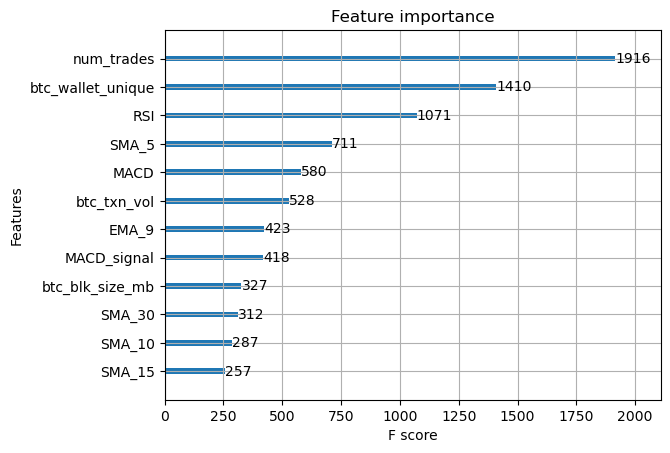

In [105]:
plot_importance(model)
plt.show()

This is a metric that simply sums up how many times each feature is split on. 

### Make & Visualize Some Predictions

In [106]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [48821.87 48821.87 49239.22 49488.85 47674.01]
y_pred = [41869.53  45782.31  45916.24  46620.305 46858.96 ]


/Users/lawrenceyim/opt/miniconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



In [113]:
print('r2 score is: ',r2_score(y_test, y_pred))
print('MSE is: ',mean_squared_error(y_test, y_pred))
print('RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAE is: ',mean_absolute_error(y_test, y_pred))
print('MAPE is: ',mean_absolute_percentage_error(y_test, y_pred))

r2 score is:  -4.122809194675496
MSE is:  30203041.739321202
RMSE is:  5495.72940921596
MAE is:  4402.50533482143
MAPE is:  0.09313531765965141


# the model is okay as a form of guidance usable. RMSE seems too high, and the MAPE of <10% is considered excellent
https://onlinelibrary.wiley.com/doi/pdf/10.1002/9781119199885.app1

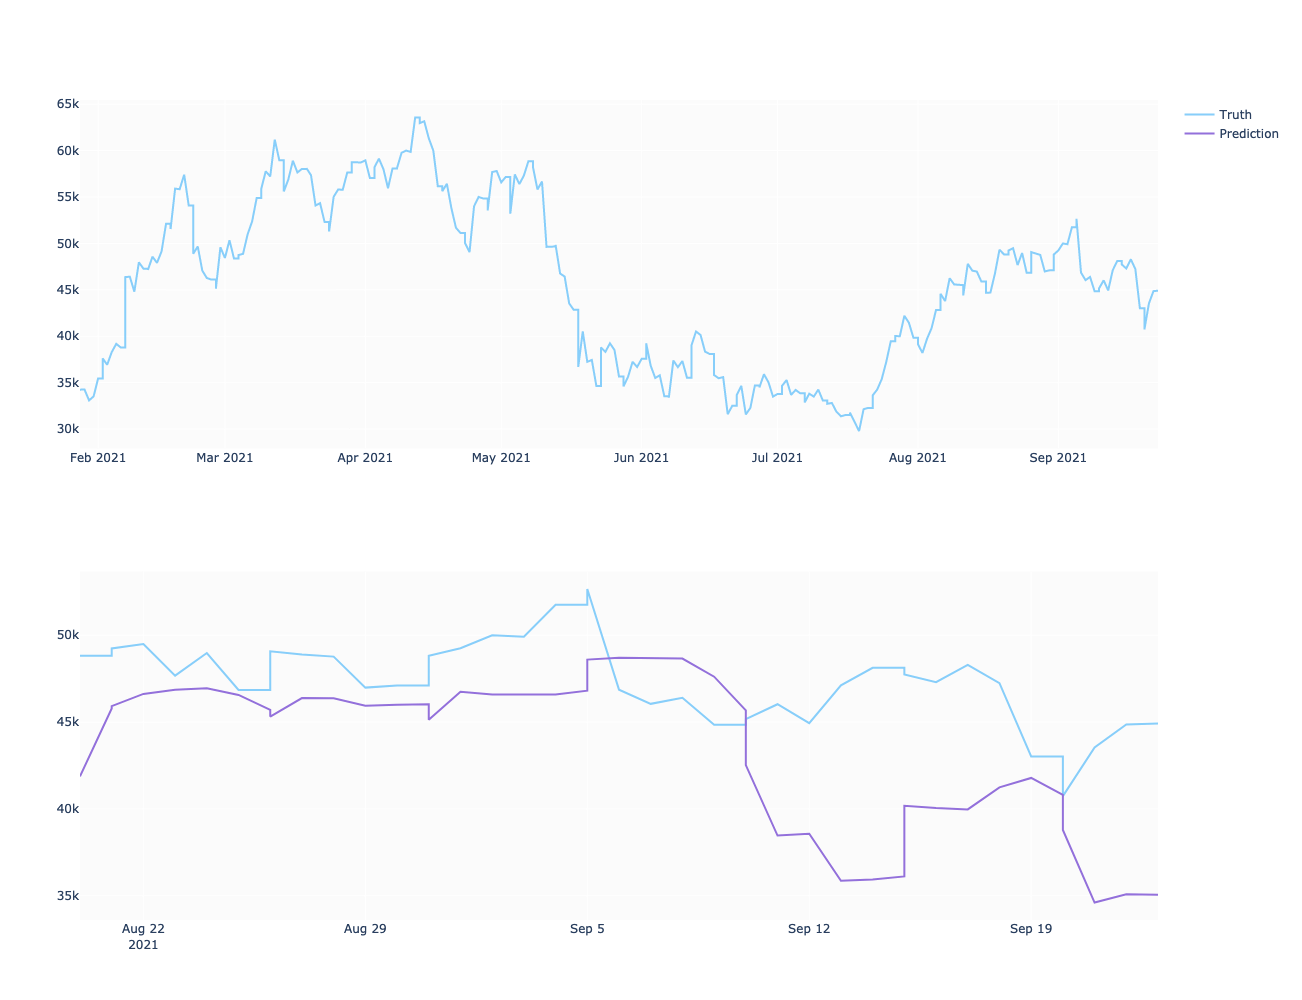

In [114]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['BTCUSDT_close'] = y_pred

fig = make_subplots(rows=2, cols=1)

fig.update_layout(
    autosize=False,
    width=1200,
    height=1000)

fig.add_trace(go.Scatter(x=df.date, y=df.BTCUSDT_close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.date,
                         y=predicted_prices.date,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()